# SVM - quick implementation on BioSeek SVM in Pyhton.

## Overview

This project is based on the original work: "Building Predictive Models for Mechanism-of-Action Classification from Phenotypic Assay Data Sets". The aim is to get a basic working idea of what's going on and get a working model. It is NOT intended to exactly replicate what the original work was doing. 

The [original work](http://journals.sagepub.com/doi/abs/10.1177/1087057113505324) built a predictive model for assigning mechanism class to compounds and bioactive agents. The model used 84 features and 309 environmental chemicals. The mechanism classes can used to evaluate the safety and efficacy of compounds and include classes such as inhibitors of mitochondrial and microtubule function, etc.

----
## Exploring the Data
Load necessary Python libraries and load the BopMAP profile data. Note that the first column ``BioMAP Viewer Mixed Profile`` is the name of the profile encoding compond name and concentration. The target label ``Mechanism`` for training and testing will be second column. For each Mechanism class multiple chemical compounds at multiple concentrations were seleccted where available.

In [14]:
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display

%matplotlib inline
pd.options.display.max_rows = 30

pd.options.display.max_columns = 300

VERBOSE = True

### Display the sample rows of data
The data file combines the compound name, concentration and unit in the first column of the file. Mechanism information is in the second column and is labeled 'Mechanism' and this will be the target to be trained on and to be predicted. The rest of the columns contain the cell system-readout values, each column labeled as such.

In [16]:
# Read in data from Excel file
data = pd.read_excel('Data/Final_Berg JBS 2013 Supplemental Table 3_For SVM14Dec2017 - Labels.xlsx')

if (VERBOSE):
    display(data.iloc[[3,4,77,80]])

,BioMAP Viewer Mixed Profile,Mechanism,BrEPI_IL-1b/TNF-a/IFN-g_24:CD87/uPAR,BrEPI_IL-1b/TNF-a/IFN-g_24:CXCL10/IP-10,BrEPI_IL-1b/TNF-a/IFN-g_24:CXCL9/MIG,BrEPI_IL-1b/TNF-a/IFN-g_24:HLA-DR,BrEPI_IL-1b/TNF-a/IFN-g_24:IL-1alpha,BrEPI_IL-1b/TNF-a/IFN-g_24:MMP-1,BrEPI_IL-1b/TNF-a/IFN-g_24:PAI-I,BrEPI_IL-1b/TNF-a/IFN-g_24:SRB,BrEPI_IL-1b/TNF-a/IFN-g_24:tPA,BrEPI_IL-1b/TNF-a/IFN-g_24:uPA,HDFn_IL-1b/TNF-a/IFN-g/EGF/FGF/PDGFbb_24:CD106/VCAM-1,HDFn_IL-1b/TNF-a/IFN-g/EGF/FGF/PDGFbb_24:Collagen III,HDFn_IL-1b/TNF-a/IFN-g/EGF/FGF/PDGFbb_24:CXCL10/IP-10,HDFn_IL-1b/TNF-a/IFN-g/EGF/FGF/PDGFbb_24:CXCL8/IL-8,HDFn_IL-1b/TNF-a/IFN-g/EGF/FGF/PDGFbb_24:CXCL9/MIG,HDFn_IL-1b/TNF-a/IFN-g/EGF/FGF/PDGFbb_24:EGFR,HDFn_IL-1b/TNF-a/IFN-g/EGF/FGF/PDGFbb_24:M-CSF,HDFn_IL-1b/TNF-a/IFN-g/EGF/FGF/PDGFbb_24:MMP-1,HDFn_IL-1b/TNF-a/IFN-g/EGF/FGF/PDGFbb_24:PAI-I,HDFn_IL-1b/TNF-a/IFN-g/EGF/FGF/PDGFbb_24:Proliferation_72hr,HDFn_IL-1b/TNF-a/IFN-g/EGF/FGF/PDGFbb_24:SRB,HDFn_IL-1b/TNF-a/IFN-g/EGF/FGF/PDGFbb_24:TIMP-2,HEK/HDFn_IL-1b/TNF-a/IFN-g/TGF-b_24:CCL2/MCP-1,HEK/HDFn_IL-1b/TNF-a/IFN-g/TGF-b_24:CD54/ICAM-1,HEK/HDFn_IL-1b/TNF-a/IFN-g/TGF-b_24:CXCL10/IP-10,HEK/HDFn_IL-1b/TNF-a/IFN-g/TGF-b_24:IL-1alpha,HEK/HDFn_IL-1b/TNF-a/IFN-g/TGF-b_24:MMP-9,HEK/HDFn_IL-1b/TNF-a/IFN-g/TGF-b_24:SRB,HEK/HDFn_IL-1b/TNF-a/IFN-g/TGF-b_24:TIMP-2,HEK/HDFn_IL-1b/TNF-a/IFN-g/TGF-b_24:uPA,HUVEC/PBMC_LPS_24:CCL2/MCP-1,HUVEC/PBMC_LPS_24:CD106/VCAM-1,HUVEC/PBMC_LPS_24:CD142/Tissue Factor,HUVEC/PBMC_LPS_24:CD40,HUVEC/PBMC_LPS_24:CD62E/E-Selectin,HUVEC/PBMC_LPS_24:CXCL8/IL-8,HUVEC/PBMC_LPS_24:IL-1alpha,HUVEC/PBMC_LPS_24:M-CSF,HUVEC/PBMC_LPS_24:sPGE2,HUVEC/PBMC_LPS_24:SRB,HUVEC/PBMC_LPS_24:sTNF-alpha,HUVEC/PBMC_SEB/TSST_24:CCL2/MCP-1,HUVEC/PBMC_SEB/TSST_24:CD38,HUVEC/PBMC_SEB/TSST_24:CD40,HUVEC/PBMC_SEB/TSST_24:CD62E/E-Selectin,HUVEC/PBMC_SEB/TSST_24:CD69,HUVEC/PBMC_SEB/TSST_24:CXCL8/IL-8,HUVEC/PBMC_SEB/TSST_24:CXCL9/MIG,HUVEC/PBMC_SEB/TSST_24:PBMC Cytotoxicity,HUVEC/PBMC_SEB/TSST_24:Proliferation,HUVEC/PBMC_SEB/TSST_24:SRB,HUVEC_IL-1b/TNF-a/IFN-g_24:CCL2/MCP-1,HUVEC_IL-1b/TNF-a/IFN-g_24:CD106/VCAM-1,HUVEC_IL-1b/TNF-a/IFN-g_24:CD141/Thrombomodulin,HUVEC_IL-1b/TNF-a/IFN-g_24:CD142/Tissue Factor,HUVEC_IL-1b/TNF-a/IFN-g_24:CD54/ICAM-1,HUVEC_IL-1b/TNF-a/IFN-g_24:CD62E/E-Selectin,HUVEC_IL-1b/TNF-a/IFN-g_24:CD87/uPAR,HUVEC_IL-1b/TNF-a/IFN-g_24:CXCL8/IL-8,HUVEC_IL-1b/TNF-a/IFN-g_24:CXCL9/MIG,HUVEC_IL-1b/TNF-a/IFN-g_24:HLA-DR,HUVEC_IL-1b/TNF-a/IFN-g_24:Proliferation,HUVEC_IL-1b/TNF-a/IFN-g_24:SRB,HUVEC_IL-4/Histamine_24:CCL2/MCP-1,HUVEC_IL-4/Histamine_24:CCL26/Eotaxin-3,HUVEC_IL-4/Histamine_24:CD106/VCAM-1,HUVEC_IL-4/Histamine_24:CD62P/P-selectin,HUVEC_IL-4/Histamine_24:CD87/uPAR,HUVEC_IL-4/Histamine_24:SRB,HUVEC_IL-4/Histamine_24:VEGFR2,CASMC_HCL_IL-1b/TNF-a/IFN-g_24:CCL2/MCP-1,CASMC_HCL_IL-1b/TNF-a/IFN-g_24:CD106/VCAM-1,CASMC_HCL_IL-1b/TNF-a/IFN-g_24:CD141/Thrombomodulin,CASMC_HCL_IL-1b/TNF-a/IFN-g_24:CD142/Tissue Factor,CASMC_HCL_IL-1b/TNF-a/IFN-g_24:CD87/uPAR,CASMC_HCL_IL-1b/TNF-a/IFN-g_24:CXCL8/IL-8,CASMC_HCL_IL-1b/TNF-a/IFN-g_24:CXCL9/MIG,CASMC_HCL_IL-1b/TNF-a/IFN-g_24:HLA-DR,CASMC_HCL_IL-1b/TNF-a/IFN-g_24:IL-6,CASMC_HCL_IL-1b/TNF-a/IFN-g_24:LDLR,CASMC_HCL_IL-1b/TNF-a/IFN-g_24:M-CSF,CASMC_HCL_IL-1b/TNF-a/IFN-g_24:Proliferation,CASMC_HCL_IL-1b/TNF-a/IFN-g_24:Serum Amyloid A,CASMC_HCL_IL-1b/TNF-a/IFN-g_24:SRB
3,"Trusted, Agents, FICZ, BSK-C016173, 37 nM",AhR agonist,0.031829,-0.008869,-0.003555,0.011887,0.030835,0.090178,-0.070916,-0.001388,0.110995,0.003789,-0.034966,-0.009998,-0.014068,0.003537,-0.015747,0.042562,-0.069212,0.052247,-0.082657,-0.005368,-0.010482,0.005129,0.009944,0.010451,-0.004175,0.019329,0.004286,-0.002770,0.017463,0.007679,0.019333,-0.024548,0.116172,-0.068569,0.037558,0.016553,0.049664,-0.098251,0.081199,-0.018213,-0.125853,0.009542,-0.003223,-0.020366,0.107481,0.011223,0.092922,-0.001923,-0.011340,-0.025316,-0.011339,-0.006891,-0.001543,-0.017243,0.121687,-0.006433,-0.005651,-0.010927,0.087580,0.001224,-0.026409,-0.087543,-0.030014,0.015798,-0.156543,-0.049247,-0.042356,-0.054239,

## Features
Each feature label is the cell type + stimulation name combined with the readout name.

In [18]:
sm = pd.DataFrame([s.split(':') for s in data.columns[2:].values.astype(str) ])
index = [sm[0].values, sm[1].values]
pd.options.display.max_rows = 84
sm.groupby([0,1]).count()

Empty DataFrame
Columns: []
Index: [(BrEPI_IL-1b/TNF-a/IFN-g_24, CD87/uPAR), (BrEPI_IL-1b/TNF-a/IFN-g_24, CXCL10/IP-10), (BrEPI_IL-1b/TNF-a/IFN-g_24, CXCL9/MIG), (BrEPI_IL-1b/TNF-a/IFN-g_24, HLA-DR), (BrEPI_IL-1b/TNF-a/IFN-g_24, IL-1alpha), (BrEPI_IL-1b/TNF-a/IFN-g_24, MMP-1), (BrEPI_IL-1b/TNF-a/IFN-g_24, PAI-I), (BrEPI_IL-1b/TNF-a/IFN-g_24, SRB), (BrEPI_IL-1b/TNF-a/IFN-g_24, tPA), (BrEPI_IL-1b/TNF-a/IFN-g_24, uPA), (CASMC_HCL_IL-1b/TNF-a/IFN-g_24, CCL2/MCP-1), (CASMC_HCL_IL-1b/TNF-a/IFN-g_24, CD106/VCAM-1), (CASMC_HCL_IL-1b/TNF-a/IFN-g_24, CD141/Thrombomodulin), (CASMC_HCL_IL-1b/TNF-a/IFN-g_24, CD142/Tissue Factor), (CASMC_HCL_IL-1b/TNF-a/IFN-g_24, CD87/uPAR), (CASMC_HCL_IL-1b/TNF-a/IFN-g_24, CXCL8/IL-8), (CASMC_HCL_IL-1b/TNF-a/IFN-g_24, CXCL9/MIG), (CASMC_HCL_IL-1b/TNF-a/IFN-g_24, HLA-DR), (CASMC_HCL_IL-1b/TNF-a/IFN-g_24, IL-6), (CASMC_HCL_IL-1b/TNF-a/IFN-g_24, LDLR), (CASMC_HCL_IL-1b/TNF-a/IFN-g_24, M-CSF), (CASMC_HCL_IL-1b/TNF-a/IFN-g_24, Proliferation), (CASMC_HCL_IL-1b/TNF-a/IFN-g_24, SRB), (CASMC_HCL_IL-1b/TNF-a/IFN-g_24, Serum Amyloid A), (HDFn_IL-1b/TNF-a/IFN-g/EGF/FGF/PDGFbb_24, CD106/VCAM-1), (HDFn_IL-1b/TNF-a/IFN-g/EGF/FGF/PDGFbb_24, CXCL10/IP-10), (HDFn_IL-1b/TNF-a/IFN-g/EGF/FGF/PDGFbb_24, CXCL8/IL-8), (HDFn_IL-1b/TNF-a/IFN-g/EGF/FGF/PDGFbb_24, CXCL9/MIG), (HDFn_IL-1b/TNF-a/IFN-g/EGF/FGF/PDGFbb_24, Collagen III), (HDFn_IL-1b/TNF-a/IFN-g/EGF/FGF/PDGFbb_24, EGFR), (HDFn_IL-1b/TNF-a/IFN-g/EGF/FGF/PDGFbb_24, M-CSF), (HDFn_IL-1b/TNF-a/IFN-g/EGF/FGF/PDGFbb_24, MMP-1), (HDFn_IL-1b/TNF-a/IFN-g/EGF/FGF/PDGFbb_24, PAI-I), (HDFn_IL-1b/TNF-a/IFN-g/EGF/FGF/PDGFbb_24, Proliferation_72hr), (HDFn_IL-1b/TNF-a/IFN-g/EGF/FGF/PDGFbb_24, SRB), (HDFn_IL-1b/TNF-a/IFN-g/EGF/FGF/PDGFbb_24, TIMP-2), (HEK/HDFn_IL-1b/TNF-a/IFN-g/TGF-b_24, CCL2/MCP-1), (HEK/HDFn_IL-1b/TNF-a/IFN-g/TGF-b_24, CD54/ICAM-1), (HEK/HDFn_IL-1b/TNF-a/IFN-g/TGF-b_24, CXCL10/IP-10), (HEK/HDFn_IL-1b/TNF-a/IFN-g/TGF-b_24, IL-1alpha), (HEK/HDFn_IL-1b/TNF-a/IFN-g/TGF-b_24, MMP-9), (HEK/HDFn_IL-1b/TNF-a/IFN-g/TGF-b_24, SRB), (HEK/HDFn_IL-1b/TNF-a/IFN-g/TGF-b_24, TIMP-2), (HEK/HDFn_IL-1b/TNF-a/IFN-g/TGF-b_24, uPA), (HUVEC/PBMC_LPS_24, CCL2/MCP-1), (HUVEC/PBMC_LPS_24, CD106/VCAM-1), (HUVEC/PBMC_LPS_24, CD142/Tissue Factor), (HUVEC/PBMC_LPS_24, CD40), (HUVEC/PBMC_LPS_24, CD62E/E-Selectin), (HUVEC/PBMC_LPS_24, CXCL8/IL-8), (HUVEC/PBMC_LPS_24, IL-1alpha), (HUVEC/PBMC_LPS_24, M-CSF), (HUVEC/PBMC_LPS_24, SRB), (HUVEC/PBMC_LPS_24, sPGE2), (HUVEC/PBMC_LPS_24, sTNF-alpha), (HUVEC/PBMC_SEB/TSST_24, CCL2/MCP-1), (HUVEC/PBMC_SEB/TSST_24, CD38), (HUVEC/PBMC_SEB/TSST_24, CD40), (HUVEC/PBMC_SEB/TSST_24, CD62E/E-Selectin), (HUVEC/PBMC_SEB/TSST_24, CD69), (HUVEC/PBMC_SEB/TSST_24, CXCL8/IL-8), (HUVEC/PBMC_SEB/TSST_24, CXCL9/MIG), (HUVEC/PBMC_SEB/TSST_24, PBMC Cytotoxicity), (HUVEC/PBMC_SEB/TSST_24, Proliferation), (HUVEC/PBMC_SEB/TSST_24, SRB), (HUVEC_IL-1b/TNF-a/IFN-g_24, CCL2/MCP-1), (HUVEC_IL-1b/TNF-a/IFN-g_24, CD106/VCAM-1), (HUVEC_IL-1b/TNF-a/IFN-g_24, CD141/Thrombomodulin), (HUVEC_IL-1b/TNF-a/IFN-g_24, CD142/Tissue Factor), (HUVEC_IL-1b/TNF-a/IFN-g_24, CD54/ICAM-1), (HUVEC_IL-1b/TNF-a/IFN-g_24, CD62E/E-Selectin), (HUVEC_IL-1b/TNF-a/IFN-g_24, CD87/uPAR), (HUVEC_IL-1b/TNF-a/IFN-g_24, CXCL8/IL-8), (HUVEC_IL-1b/TNF-a/IFN-g_24, CXCL9/MIG), (HUVEC_IL-1b/TNF-a/IFN-g_24, HLA-DR), (HUVEC_IL-1b/TNF-a/IFN-g_24, Proliferation), (HUVEC_IL-1b/TNF-a/IFN-g_24, SRB), (HUVEC_IL-4/Histamine_24, CCL2/MCP-1), (HUVEC_IL-4/Histamine_24, CCL26/Eotaxin-3), (HUVEC_IL-4/Histamine_24, CD106/VCAM-1), (HUVEC_IL-4/Histamine_24, CD62P/P-selectin), (HUVEC_IL-4/Histamine_24, CD87/uPAR), (HUVEC_IL-4/Histamine_24, SRB), (HUVEC_IL-4/Histamine_24, VEGFR2)]

### Explore Mechanism Classes as Training Labels
Mechanism class will be the target of the prediction. There are a varying number of examples per class, the table below lists the counts of each mechanism class.

In [21]:
pd.options.display.max_rows = 30
print("Number of unique Mechanisms: {}".format(data['Mechanism'].nunique()))
m_gb = data.groupby('Mechanism').size()
dfs = pd.DataFrame(m_gb, columns=['Profile Count'])

if VERBOSE: display( dfs.sort_values(['Profile Count'], ascending=False))

Number of unique Mechanisms: 28


,Profile Count
Mechanism,
mTOR inhibitor,27
HMG-CoA reductase inhibitor,25
Mitochondrial inhibitor,24
Microtubule disruptor,18
Microtubule stabilizer,18
GR agonist,16
RAR/RXR agonist,15
PDE IV inhibitor,15
p38 MAPK inhibitor,14


## Explore distributin of data amoung mechanism classes
Due to the large number of classes the visuals are listed in a separate workbook. []()

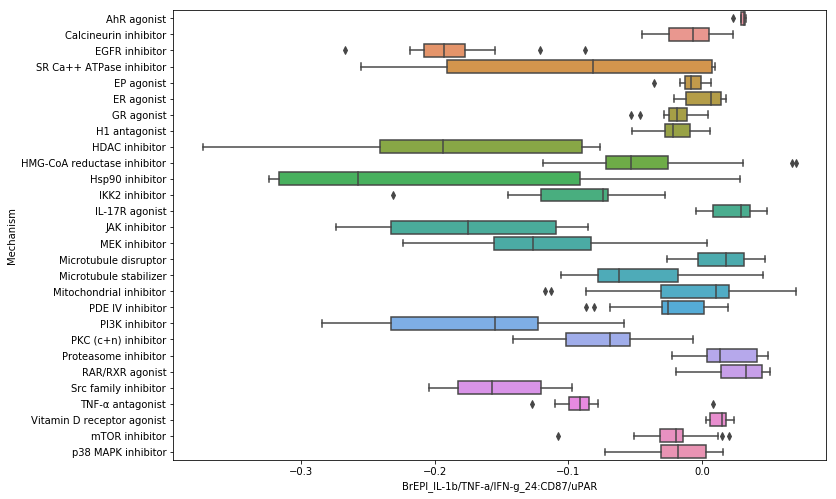

In [3]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
# the size of A4 paper
fig.set_size_inches(11.7, 8.27)
sns.boxplot(data=data[['Mechanism','BrEPI_IL-1b/TNF-a/IFN-g_24:CD87/uPAR']], 
            y='Mechanism', x='BrEPI_IL-1b/TNF-a/IFN-g_24:CD87/uPAR')

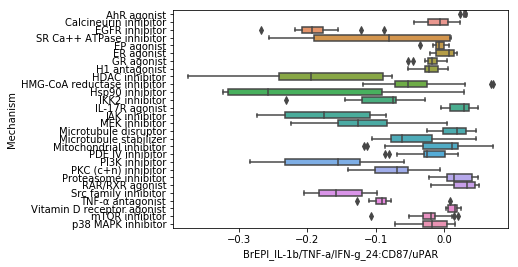

In [4]:
sns.boxplot(data=data[['Mechanism','BrEPI_IL-1b/TNF-a/IFN-g_24:CD87/uPAR']], 
            y='Mechanism', x='BrEPI_IL-1b/TNF-a/IFN-g_24:CD87/uPAR')

In [9]:
# Split the data into training and testing. We'll work with the raw features and labels set to normalize and encode where needed.
## Split out labels from data
profile_names = data['BioMAP Viewer Mixed Profile'] # save this for later reference
labels_raw = data['Mechanism']

if DEBUG: display(pd.DataFrame(pd.DataFrame(labels_raw).groupby('Mechanism').size(), columns=['Profile Count']).sort_values(['Profile Count'], ascending=False))
features_raw = data.drop(['Mechanism'], axis = 1)
print("Number of unique Mechanisms: {}".format(len(labels_raw.unique())))


,Profile Count
Mechanism,
mTOR inhibitor,27
HMG-CoA reductase inhibitor,25
Mitochondrial inhibitor,24
Microtubule disruptor,18
Microtubule stabilizer,18
GR agonist,16
RAR/RXR agonist,15
PDE IV inhibitor,15
p38 MAPK inhibitor,14


Number of unique Mechanisms: 28


### Explore the features
Looka the distributiona and correlation among Parameters.
The data has missing data. We'll need to fill in the missing data points for SVM to work correctly and we'll need to scale the data. The original work used 

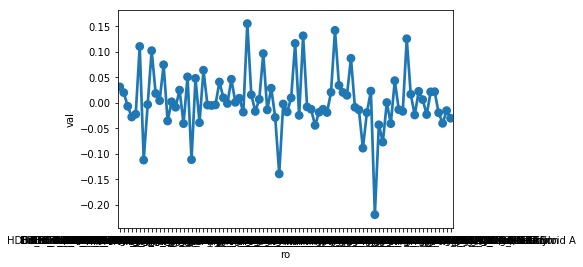

In [83]:
# Print out distribution of reaout
#pd.DataFrame(features_raw.loc[0,:]).plot.hist()
n = np.array(features_raw.loc[0,:][1:].index)
n
v = features_raw.loc[0,:][1:].values
pr = pd.DataFrame({'ro': n, 'val':v})
sns.pointplot(data=pr, x='ro', y='val')


In [5]:
features_raw = data.drop(['Mechanism'], axis = 1)
# Print out basic info about the data
# features_raw.info()
num_profiles = features_raw.shape[0]
num_features = features_raw.shape[1]-1
print("Number of Trainig Profiles: " + str(num_profiles))
print("Number of Features: " + str(num_features))

# Print out the features (system-marker) list
feature_list = pd.Series(features_raw.columns)
if DEBUG: data.columns
feature_list

Number of Trainig Profiles: 327
Number of Features: 84


0                        BioMAP Viewer Mixed Profile
1               BrEPI_IL-1b/TNF-a/IFN-g_24:CD87/uPAR
2            BrEPI_IL-1b/TNF-a/IFN-g_24:CXCL10/IP-10
3               BrEPI_IL-1b/TNF-a/IFN-g_24:CXCL9/MIG
4                  BrEPI_IL-1b/TNF-a/IFN-g_24:HLA-DR
5               BrEPI_IL-1b/TNF-a/IFN-g_24:IL-1alpha
6                   BrEPI_IL-1b/TNF-a/IFN-g_24:MMP-1
                           ...                      
78             CASMC_HCL_IL-1b/TNF-a/IFN-g_24:HLA-DR
79               CASMC_HCL_IL-1b/TNF-a/IFN-g_24:IL-6
80               CASMC_HCL_IL-1b/TNF-a/IFN-g_24:LDLR
81              CASMC_HCL_IL-1b/TNF-a/IFN-g_24:M-CSF
82      CASMC_HCL_IL-1b/TNF-a/IFN-g_24:Proliferation
83    CASMC_HCL_IL-1b/TNF-a/IFN-g_24:Serum Amyloid A
84                CASMC_HCL_IL-1b/TNF-a/IFN-g_24:SRB
Length: 85, dtype: object

In [6]:
features_raw.describe()

,BrEPI_IL-1b/TNF-a/IFN-g_24:CD87/uPAR,BrEPI_IL-1b/TNF-a/IFN-g_24:CXCL10/IP-10,BrEPI_IL-1b/TNF-a/IFN-g_24:CXCL9/MIG,BrEPI_IL-1b/TNF-a/IFN-g_24:HLA-DR,BrEPI_IL-1b/TNF-a/IFN-g_24:IL-1alpha,BrEPI_IL-1b/TNF-a/IFN-g_24:MMP-1,BrEPI_IL-1b/TNF-a/IFN-g_24:PAI-I,BrEPI_IL-1b/TNF-a/IFN-g_24:SRB,BrEPI_IL-1b/TNF-a/IFN-g_24:tPA,BrEPI_IL-1b/TNF-a/IFN-g_24:uPA,HDFn_IL-1b/TNF-a/IFN-g/EGF/FGF/PDGFbb_24:CD106/VCAM-1,HDFn_IL-1b/TNF-a/IFN-g/EGF/FGF/PDGFbb_24:Collagen III,HDFn_IL-1b/TNF-a/IFN-g/EGF/FGF/PDGFbb_24:CXCL10/IP-10,HDFn_IL-1b/TNF-a/IFN-g/EGF/FGF/PDGFbb_24:CXCL8/IL-8,HDFn_IL-1b/TNF-a/IFN-g/EGF/FGF/PDGFbb_24:CXCL9/MIG,HDFn_IL-1b/TNF-a/IFN-g/EGF/FGF/PDGFbb_24:EGFR,HDFn_IL-1b/TNF-a/IFN-g/EGF/FGF/PDGFbb_24:M-CSF,HDFn_IL-1b/TNF-a/IFN-g/EGF/FGF/PDGFbb_24:MMP-1,HDFn_IL-1b/TNF-a/IFN-g/EGF/FGF/PDGFbb_24:PAI-I,HDFn_IL-1b/TNF-a/IFN-g/EGF/FGF/PDGFbb_24:Proliferation_72hr,HDFn_IL-1b/TNF-a/IFN-g/EGF/FGF/PDGFbb_24:SRB,HDFn_IL-1b/TNF-a/IFN-g/EGF/FGF/PDGFbb_24:TIMP-2,HEK/HDFn_IL-1b/TNF-a/IFN-g/TGF-b_24:CCL2/MCP-1,HEK/HDFn_IL-1b/TNF-a/IFN-g/TGF-b_24:CD54/ICAM-1,HEK/HDFn_IL-1b/TNF-a/IFN-g/TGF-b_24:CXCL10/IP-10,HEK/HDFn_IL-1b/TNF-a/IFN-g/TGF-b_24:IL-1alpha,HEK/HDFn_IL-1b/TNF-a/IFN-g/TGF-b_24:MMP-9,HEK/HDFn_IL-1b/TNF-a/IFN-g/TGF-b_24:SRB,HEK/HDFn_IL-1b/TNF-a/IFN-g/TGF-b_24:TIMP-2,HEK/HDFn_IL-1b/TNF-a/IFN-g/TGF-b_24:uPA,HUVEC/PBMC_LPS_24:CCL2/MCP-1,HUVEC/PBMC_LPS_24:CD106/VCAM-1,HUVEC/PBMC_LPS_24:CD142/Tissue Factor,HUVEC/PBMC_LPS_24:CD40,HUVEC/PBMC_LPS_24:CD62E/E-Selectin,HUVEC/PBMC_LPS_24:CXCL8/IL-8,HUVEC/PBMC_LPS_24:IL-1alpha,HUVEC/PBMC_LPS_24:M-CSF,HUVEC/PBMC_LPS_24:sPGE2,HUVEC/PBMC_LPS_24:SRB,HUVEC/PBMC_LPS_24:sTNF-alpha,HUVEC/PBMC_SEB/TSST_24:CCL2/MCP-1,HUVEC/PBMC_SEB/TSST_24:CD38,HUVEC/PBMC_SEB/TSST_24:CD40,HUVEC/PBMC_SEB/TSST_24:CD62E/E-Selectin,HUVEC/PBMC_SEB/TSST_24:CD69,HUVEC/PBMC_SEB/TSST_24:CXCL8/IL-8,HUVEC/PBMC_SEB/TSST_24:CXCL9/MIG,HUVEC/PBMC_SEB/TSST_24:PBMC Cytotoxicity,HUVEC/PBMC_SEB/TSST_24:Proliferation,HUVEC/PBMC_SEB/TSST_24:SRB,HUVEC_IL-1b/TNF-a/IFN-g_24:CCL2/MCP-1,HUVEC_IL-1b/TNF-a/IFN-g_24:CD106/VCAM-1,HUVEC_IL-1b/TNF-a/IFN-g_24:CD141/Thrombomodulin,HUVEC_IL-1b/TNF-a/IFN-g_24:CD142/Tissue Factor,HUVEC_IL-1b/TNF-a/IFN-g_24:CD54/ICAM-1,HUVEC_IL-1b/TNF-a/IFN-g_24:CD62E/E-Selectin,HUVEC_IL-1b/TNF-a/IFN-g_24:CD87/uPAR,HUVEC_IL-1b/TNF-a/IFN-g_24:CXCL8/IL-8,HUVEC_IL-1b/TNF-a/IFN-g_24:CXCL9/MIG,HUVEC_IL-1b/TNF-a/IFN-g_24:HLA-DR,HUVEC_IL-1b/TNF-a/IFN-g_24:Proliferation,HUVEC_IL-1b/TNF-a/IFN-g_24:SRB,HUVEC_IL-4/Histamine_24:CCL2/MCP-1,HUVEC_IL-4/Histamine_24:CCL26/Eotaxin-3,HUVEC_IL-4/Histamine_24:CD106/VCAM-1,HUVEC_IL-4/Histamine_24:CD62P/P-selectin,HUVEC_IL-4/Histamine_24:CD87/uPAR,HUVEC_IL-4/Histamine_24:SRB,HUVEC_IL-4/Histamine_24:VEGFR2,CASMC_HCL_IL-1b/TNF-a/IFN-g_24:CCL2/MCP-1,CASMC_HCL_IL-1b/TNF-a/IFN-g_24:CD106/VCAM-1,CASMC_HCL_IL-1b/TNF-a/IFN-g_24:CD141/Thrombomodulin,CASMC_HCL_IL-1b/TNF-a/IFN-g_24:CD142/Tissue Factor,CASMC_HCL_IL-1b/TNF-a/IFN-g_24:CD87/uPAR,CASMC_HCL_IL-1b/TNF-a/IFN-g_24:CXCL8/IL-8,CASMC_HCL_IL-1b/TNF-a/IFN-g_24:CXCL9/MIG,CASMC_HCL_IL-1b/TNF-a/IFN-g_24:HLA-DR,CASMC_HCL_IL-1b/TNF-a/IFN-g_24:IL-6,CASMC_HCL_IL-1b/TNF-a/IFN-g_24:LDLR,CASMC_HCL_IL-1b/TNF-a/IFN-g_24:M-CSF,CASMC_HCL_IL-1b/TNF-a/IFN-g_24:Proliferation,CASMC_HCL_IL-1b/TNF-a/IFN-g_24:Serum Amyloid A,CASMC_HCL_IL-1b/TNF-a/IFN-g_24:SRB
count,324.000000,324.000000,324.000000,324.000000,324.000000,324.000000,324.000000,324.000000,324.000000,324.000000,327.000000,327.000000,327.000000,327.000000,327.000000,327.000000,327.000000,327.000000,327.000000,327.000000,327.000000,318.000000,320.000000,320.000000,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000,326.000000,327.000000,327.000000,327.000000,327.000000,327.000000,326.000000,327.000000,326.000000,327.000000,326.000000,327.000000,327.000000,327.000000,327.000000,327.000000,327.000000,327.000000,326.000000,326.000000,327.000000,327.000000,327.000000,326.000000,326.000000,326.000000,327.000000,327.000000,326.000000,326.000000,327.000000,327.000000,327.000000,324.000000,327.000000,327.000000,326.000000,327

In [7]:
# Profiles/Mechanisms with missing data
pd.options.display.max_rows = 50

pmv = data[data.isnull().any(axis=1)]
print("Number of profiles with missing values: {}".format(len(pmv)))
pmv.iloc[:,0:2]

Number of profiles with missing values: 23


,BioMAP Viewer Mixed Profile,Mechanism
25,"Trusted, Agents, Gefitinib, BSK-C016173, 1000 nM",EGFR inhibitor
26,"Trusted, Agents, Gefitinib, BSK-C016173, 111.1 nM",EGFR inhibitor
27,"Trusted, Agents, Gefitinib, BSK-C016173, 3000 nM",EGFR inhibitor
28,"Trusted, Agents, Gefitinib, BSK-C016173, 333.3 nM",EGFR inhibitor
41,"Trusted, Agents, 17alpha-Ethynylestradiol, BSK...",ER agonist
42,"Trusted, Agents, 17alpha-Ethynylestradiol, BSK...",ER agonist
44,"Trusted, Agents, 17beta-Estradiol, BSK-C016173...",ER agonist
58,"Trusted, Agents, Prednisolone, BSK-C016173, 10...",GR agonist
76,"Trusted, Agents, Trichostatin A, BSK-C016173, ...",HDAC inhibitor
77,"Trusted, Agents, Trichostatin A, BSK-C016173, ...",HDAC inhibitor


In [11]:
# System-readouts with missing values
mv = np.array(features_raw.isnull().any(axis=0))
s = features_raw.loc[:,mv]

print("Number of System-readouts with missing values: {}".format(len(features_raw.columns[mv])))
if DEBUG: display(pd.DataFrame(features_raw.columns[mv], columns=['Profiles with Missing Values']))

Number of System-readouts with missing values: 46


,Profiles with Missing Values
0,BrEPI_IL-1b/TNF-a/IFN-g_24:CD87/uPAR
1,BrEPI_IL-1b/TNF-a/IFN-g_24:CXCL10/IP-10
2,BrEPI_IL-1b/TNF-a/IFN-g_24:CXCL9/MIG
3,BrEPI_IL-1b/TNF-a/IFN-g_24:HLA-DR
4,BrEPI_IL-1b/TNF-a/IFN-g_24:IL-1alpha
5,BrEPI_IL-1b/TNF-a/IFN-g_24:MMP-1
6,BrEPI_IL-1b/TNF-a/IFN-g_24:PAI-I
7,BrEPI_IL-1b/TNF-a/IFN-g_24:SRB
8,BrEPI_IL-1b/TNF-a/IFN-g_24:tPA
9,BrEPI_IL-1b/TNF-a/IFN-g_24:uPA


In [48]:
# fill in missing values with within-group mean
# https://pandas.pydata.org/pandas-docs/stable/groupby.html
tr = data.drop(['BioMAP Viewer Mixed Profile'], axis=1)
grouped = features_raw.groupby(data["Mechanism"])
grouped.count()
f = lambda x: x.fillna(x.mean())
features_transformed = grouped.transform(f)
features_transformed[75:82]



,BrEPI_IL-1b/TNF-a/IFN-g_24:CD87/uPAR,BrEPI_IL-1b/TNF-a/IFN-g_24:CXCL10/IP-10,BrEPI_IL-1b/TNF-a/IFN-g_24:CXCL9/MIG,BrEPI_IL-1b/TNF-a/IFN-g_24:HLA-DR,BrEPI_IL-1b/TNF-a/IFN-g_24:IL-1alpha,BrEPI_IL-1b/TNF-a/IFN-g_24:MMP-1,BrEPI_IL-1b/TNF-a/IFN-g_24:PAI-I,BrEPI_IL-1b/TNF-a/IFN-g_24:SRB,BrEPI_IL-1b/TNF-a/IFN-g_24:tPA,BrEPI_IL-1b/TNF-a/IFN-g_24:uPA,HDFn_IL-1b/TNF-a/IFN-g/EGF/FGF/PDGFbb_24:CD106/VCAM-1,HDFn_IL-1b/TNF-a/IFN-g/EGF/FGF/PDGFbb_24:Collagen III,HDFn_IL-1b/TNF-a/IFN-g/EGF/FGF/PDGFbb_24:CXCL10/IP-10,HDFn_IL-1b/TNF-a/IFN-g/EGF/FGF/PDGFbb_24:CXCL8/IL-8,HDFn_IL-1b/TNF-a/IFN-g/EGF/FGF/PDGFbb_24:CXCL9/MIG,HDFn_IL-1b/TNF-a/IFN-g/EGF/FGF/PDGFbb_24:EGFR,HDFn_IL-1b/TNF-a/IFN-g/EGF/FGF/PDGFbb_24:M-CSF,HDFn_IL-1b/TNF-a/IFN-g/EGF/FGF/PDGFbb_24:MMP-1,HDFn_IL-1b/TNF-a/IFN-g/EGF/FGF/PDGFbb_24:PAI-I,HDFn_IL-1b/TNF-a/IFN-g/EGF/FGF/PDGFbb_24:Proliferation_72hr,HDFn_IL-1b/TNF-a/IFN-g/EGF/FGF/PDGFbb_24:SRB,HDFn_IL-1b/TNF-a/IFN-g/EGF/FGF/PDGFbb_24:TIMP-2,HEK/HDFn_IL-1b/TNF-a/IFN-g/TGF-b_24:CCL2/MCP-1,HEK/HDFn_IL-1b/TNF-a/IFN-g/TGF-b_24:CD54/ICAM-1,HEK/HDFn_IL-1b/TNF-a/IFN-g/TGF-b_24:CXCL10/IP-10,HEK/HDFn_IL-1b/TNF-a/IFN-g/TGF-b_24:IL-1alpha,HEK/HDFn_IL-1b/TNF-a/IFN-g/TGF-b_24:MMP-9,HEK/HDFn_IL-1b/TNF-a/IFN-g/TGF-b_24:SRB,HEK/HDFn_IL-1b/TNF-a/IFN-g/TGF-b_24:TIMP-2,HEK/HDFn_IL-1b/TNF-a/IFN-g/TGF-b_24:uPA,HUVEC/PBMC_LPS_24:CCL2/MCP-1,HUVEC/PBMC_LPS_24:CD106/VCAM-1,HUVEC/PBMC_LPS_24:CD142/Tissue Factor,HUVEC/PBMC_LPS_24:CD40,HUVEC/PBMC_LPS_24:CD62E/E-Selectin,HUVEC/PBMC_LPS_24:CXCL8/IL-8,HUVEC/PBMC_LPS_24:IL-1alpha,HUVEC/PBMC_LPS_24:M-CSF,HUVEC/PBMC_LPS_24:sPGE2,HUVEC/PBMC_LPS_24:SRB,HUVEC/PBMC_LPS_24:sTNF-alpha,HUVEC/PBMC_SEB/TSST_24:CCL2/MCP-1,HUVEC/PBMC_SEB/TSST_24:CD38,HUVEC/PBMC_SEB/TSST_24:CD40,HUVEC/PBMC_SEB/TSST_24:CD62E/E-Selectin,HUVEC/PBMC_SEB/TSST_24:CD69,HUVEC/PBMC_SEB/TSST_24:CXCL8/IL-8,HUVEC/PBMC_SEB/TSST_24:CXCL9/MIG,HUVEC/PBMC_SEB/TSST_24:PBMC Cytotoxicity,HUVEC/PBMC_SEB/TSST_24:Proliferation,HUVEC/PBMC_SEB/TSST_24:SRB,HUVEC_IL-1b/TNF-a/IFN-g_24:CCL2/MCP-1,HUVEC_IL-1b/TNF-a/IFN-g_24:CD106/VCAM-1,HUVEC_IL-1b/TNF-a/IFN-g_24:CD141/Thrombomodulin,HUVEC_IL-1b/TNF-a/IFN-g_24:CD142/Tissue Factor,HUVEC_IL-1b/TNF-a/IFN-g_24:CD54/ICAM-1,HUVEC_IL-1b/TNF-a/IFN-g_24:CD62E/E-Selectin,HUVEC_IL-1b/TNF-a/IFN-g_24:CD87/uPAR,HUVEC_IL-1b/TNF-a/IFN-g_24:CXCL8/IL-8,HUVEC_IL-1b/TNF-a/IFN-g_24:CXCL9/MIG,HUVEC_IL-1b/TNF-a/IFN-g_24:HLA-DR,HUVEC_IL-1b/TNF-a/IFN-g_24:Proliferation,HUVEC_IL-1b/TNF-a/IFN-g_24:SRB,HUVEC_IL-4/Histamine_24:CCL2/MCP-1,HUVEC_IL-4/Histamine_24:CCL26/Eotaxin-3,HUVEC_IL-4/Histamine_24:CD106/VCAM-1,HUVEC_IL-4/Histamine_24:CD62P/P-selectin,HUVEC_IL-4/Histamine_24:CD87/uPAR,HUVEC_IL-4/Histamine_24:SRB,HUVEC_IL-4/Histamine_24:VEGFR2,CASMC_HCL_IL-1b/TNF-a/IFN-g_24:CCL2/MCP-1,CASMC_HCL_IL-1b/TNF-a/IFN-g_24:CD106/VCAM-1,CASMC_HCL_IL-1b/TNF-a/IFN-g_24:CD141/Thrombomodulin,CASMC_HCL_IL-1b/TNF-a/IFN-g_24:CD142/Tissue Factor,CASMC_HCL_IL-1b/TNF-a/IFN-g_24:CD87/uPAR,CASMC_HCL_IL-1b/TNF-a/IFN-g_24:CXCL8/IL-8,CASMC_HCL_IL-1b/TNF-a/IFN-g_24:CXCL9/MIG,CASMC_HCL_IL-1b/TNF-a/IFN-g_24:HLA-DR,CASMC_HCL_IL-1b/TNF-a/IFN-g_24:IL-6,CASMC_HCL_IL-1b/TNF-a/IFN-g_24:LDLR,CASMC_HCL_IL-1b/TNF-a/IFN-g_24:M-CSF,CASMC_HCL_IL-1b/TNF-a/IFN-g_24:Proliferation,CASMC_HCL_IL-1b/TNF-a/IFN-g_24:Serum Amyloid A,CASMC_HCL_IL-1b/TNF-a/IFN-g_24:SRB
75,-0.076612,0.034877,-0.000263,-0.043693,0.000339,-0.027887,0.014458,-0.000808,0.183085,-0.089200,-0.133475,-0.165537,-0.122668,0.003348,-0.030063,-0.136353,0.034072,-0.001216,-0.047831,-0.214047,-0.027018,-0.023269,-0.020482,0.020295,0.013915,0.041436,-0.009538,-0.005869,-0.054989,-0.047902,-0.028699,-0.053771,-0.027701,-0.038767,-0.031290,-0.000108,-0.080809,-0.121783,-0.033856,-0.003580,-0.647514,0.046309,-0.146581,-0.003253,0.199833,-0.001711,0.124583,-0.001801,-0.032304,-0.267673,0.010673,0.023688,-0.000806,0.067109,0.032913,0.047723,0.175068,-0.063466,0.031112,0.040770,-0.029753,-0.128460,-0.022841,0.030668,-0.006178,0.003596,-0.041531,0.008476,-0.013020,0.027741,-0.036015,-0.118212,-0.006982,0.149940,-0.063395,-0.000249,-0.06045

In [49]:
## Generate Training and Tesing sets
from sklearn.model_selection import train_test_split

features_train, features_test, labels_train, labels_test = train_test_split(features_transformed, 
                                                                            labels_encoded, 
                                                                            test_size = 0.2, 
                                                                            random_state = 0)

print("Training set has {} samples.".format(features_train.shape[0]))
print("Testing  set has {} samples.".format(features_test.shape[0]))

      


Training set has 261 samples.
Testing  set has 66 samples.


### Model Application
Use Linear SVC model using one-vs-all strategy as a first attemp

In [50]:
# import modules used to train and evaluate model
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, fbeta_score, make_scorer


clf = OneVsRestClassifier(LinearSVC(random_state=0))
parameters = {'estimator__C': [0.1, 1, 10, 100, 1000]}
#clf = clf.fit(features_train, labels_train)



In [51]:
# set beta to 0.5 for bias towards higher accuracy
#scorer = make_scorer(fbeta_score, beta=0.5, average=None) # average=None means scores are returned for each class
scorer = make_scorer(accuracy_score) # average=None means scores are returned for each class


grid_obj = GridSearchCV(clf, param_grid=parameters, scoring=scorer)
grid_fit = grid_obj.fit(features_train, labels_train)

best_clf = grid_fit.best_estimator_

# Optimized predictions

predictions_test = best_clf.predict(features_test)
predictions_train = best_clf.predict(features_train)

fbeta_test = fbeta_score(labels_test, predictions_test, beta=0.5, average=None)
accuracy_test = accuracy_score(labels_test, predictions_test)

print("F-beta on testing data: {}".format(fbeta_test))
print("Accuracy on testing data: {}".format(accuracy_test))



# Unoptimized results

# predictions_test = clf.predict(features_test)
# predictions_train = clf.predict(features_train)


#acc_test = accuracy_score(prediction_test, labels_test)

#fbeta_test  = fbeta_score(prediction_test, beta=0.5)

#print("Training Accuracy: {:.4f}".format(acc_train))
#print("Testing  Accuracy: {:.4f}".format(acc_test))

#print("Training F-Beta: {:.4f}".format(fbeta_train))
#print("Training F-Beta: {:.4f}".format(fbeta_test))

F-beta on testing data: [ 0.  1.  1.  0.  0.  1.  1.  1.  1.  1.  1.  0.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  0.  1.  1.  0.  1.  1.]
Accuracy on testing data: 1.0


C:\Users\antalb\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\antalb\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


### Model Evaluation
Evaluate the model using TPR and Fbeta sore

## References: 
Building Predictive Models for Mechanism-of-Action Classification from Phenotypic Assay Data Sets http://journals.sagepub.com/doi/abs/10.1177/1087057113505324